# Imports

In [1530]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

# Parameters

In [1531]:
PRM_PCT_TST = 0.2 # Percantage of samples for the test set
PRM_PCT_VLD_FROM_TRN = 0.2 # Percantage of samples from the complete training set for the validation set
PRM_RND = 23 # Random seed

In [1532]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## Read the data

In [1533]:
df = pd.read_csv('stroke_data.csv')

## Dataset outline

### Observe a few rows

In [1534]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Female,80.0,0,1,Yes,Self-employed,Urban,67.45,25.6,never smoked,0
1,4,Female,37.0,0,0,Yes,Private,Rural,82.15,24.3,smokes,0
2,6,Female,21.0,0,0,No,Private,Urban,75.73,NaN,never smoked,0
3,7,Female,44.0,0,0,Yes,Private,Urban,222.75,19.6,never smoked,0
4,8,Female,79.0,0,0,Yes,Private,Urban,99.23,25.1,NaN,0


### Get the shape of the dataset

In [1535]:
df.shape

(43400, 12)

### Make sure that each ID shows only once

In [1536]:
len(df['id'].unique())

43400

## Partition the data

Training / Test sets

In [1537]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('stroke', axis = 1) # X
    ,df['stroke'] # y
    ,test_size = PRM_PCT_TST
    ,random_state = PRM_RND
    ,shuffle = True
    ,stratify = None
)

Sub-training / Validation sets

In [1538]:
X_sub_train, X_validation, y_sub_train, y_validation = train_test_split(
    X_train # X
    ,y_train # y
    ,test_size = PRM_PCT_VLD_FROM_TRN
    ,random_state = PRM_RND
    ,shuffle = True
    ,stratify = None
)

## Explore the training set

### Class distribution

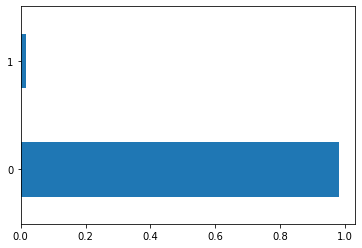

In [1539]:
y_sub_train.value_counts(
    dropna = False
    ,normalize = True
).plot.barh()

# --> Highly imbalanced (approximately 98% - 2%)
# --> Consider resampling during training

### Overview of (potential) predictors

In [1540]:
X_sub_train.shape # Count of rows & columns

(27776, 11)

In [1541]:
# Identify features with missing values
# Make sure that the data type is correct
X_sub_train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27776 entries, 19365 to 25821
Data columns (total 11 columns):
id                   27776 non-null int64
gender               27776 non-null object
age                  27776 non-null float64
hypertension         27776 non-null int64
heart_disease        27776 non-null int64
ever_married         27776 non-null object
work_type            27776 non-null object
Residence_type       27776 non-null object
avg_glucose_level    27776 non-null float64
bmi                  26827 non-null float64
smoking_status       19267 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 2.5+ MB


In [1542]:
X_sub_train.describe() # Statistics regrading the numeric features

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,27776.000000,27776.000000,27776.000000,27776.000000,27776.000000,26827.000000
mean,36373.908950,42.140514,0.093750,0.048063,104.217291,28.587457
std,21044.229304,22.540124,0.291486,0.213903,42.976015,7.728739
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.300000
25%,18070.000000,24.000000,0.000000,0.000000,77.400000,23.200000
50%,36430.500000,44.000000,0.000000,0.000000,91.450000,27.700000
75%,54532.250000,60.000000,0.000000,0.000000,111.760000,32.800000
max,72939.000000,82.000000,1.000000,1.000000,291.050000,89.100000


In [1543]:
X_sub_train['gender'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# Relatively balanced, makes sense
# --> Keep 'Other', might be difficult to infer on the validation / test set

Female    0.591806
Male      0.407834
Other     0.000360
Name: gender, dtype: float64

In [1544]:
X_sub_train['hypertension'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems realistic

0    0.90625
1    0.09375
Name: hypertension, dtype: float64

In [1545]:
X_sub_train['heart_disease'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems realistic

0    0.951937
1    0.048063
Name: heart_disease, dtype: float64

In [1546]:
X_sub_train['ever_married'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems realistic

Yes    0.641813
No     0.358187
Name: ever_married, dtype: float64

In [1547]:
X_sub_train['work_type'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems realistic

Private          0.573409
Self-employed    0.154846
children         0.143001
Govt_job         0.125072
Never_worked     0.003672
Name: work_type, dtype: float64

In [1548]:
X_sub_train['Residence_type'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems OK, although probably not from Israel (biased towards 'Rural')

Urban    0.503312
Rural    0.496688
Name: Residence_type, dtype: float64

In [1549]:
pd.crosstab(
    X_sub_train['ever_married']
    ,X_sub_train['hypertension']
    ,dropna = False
    ,normalize = 'index'
)

# Interesting...

hypertension,0,1
ever_married,,
No,0.974972,0.025028
Yes,0.867897,0.132103


### Preliminary insights, questions and decisions

Insights
* __Age__: Min seems questionable yet OK
* __gender__:                 
* __Hypertension__: [Possibly stands for](https://en.wikipedia.org/wiki/Hypertension#:~:text=Hypertension%20(HTN%20or%20HT)%2C,typically%20does%20not%20cause%20symptoms.) "HT / HTN / High Blood Pressure / HBP"; The range seems like [0, 1], so probably boolean
* __Heart_disease__: Probably boolean
* __ever_married__: 
* __work_type__: 
* __Residence_type__: 
* __Avg_glucose_level__: Probably in [terms of](https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html) mg/dL rather than mmol/L; Levels above 200 may indicate diabetes
* __bmi__: Body Mass Index, levels above 40 [indicate](https://en.wikipedia.org/wiki/Body_mass_index) Class III Obesity (Very severely obese), here we have much more; also 949 missing values (~3.4%)
* __smoking_status__: 8,509 missing values (~30.6%)

Questions
* Are babies taken into account? Some values are really low

Decisions
* bmi: Clip at 40 (upper bound)
* bmi: Remove missing values from the training set, impute in the validation & test sets using the training's median
* smoking_status: Check if missing implies 'non-smoking'
* All of the features have some variability (i.e., they are not constant), so none can be disqualified due to near-zero variance
* The feature set is quite small and intuitively correlated with the target, so no feature selection is undertaken
* __put all of the insights into a preprocessing function__


In [1550]:
# Distribution
X_sub_train['smoking_status'].value_counts(dropna = False)

never smoked       10272
NaN                 8509
formerly smoked     4814
smokes              4181
Name: smoking_status, dtype: int64

In [1551]:
# Look for unreal combinations, e.g., baby smokers
X_sub_train[['age', 'smoking_status']].copy().sort_values(
    by = 'age'
    ,ascending = True
).head(n = 15)

,age,smoking_status
34498,0.08,NaN
7837,0.08,NaN
25940,0.08,NaN
21869,0.08,NaN
4855,0.08,NaN
17933,0.08,NaN
20610,0.08,NaN
24294,0.08,NaN
36914,0.08,NaN
6493,0.08,NaN


In [1552]:
# What is the age distribution for unknown smoking status?
X_sub_train[X_sub_train['smoking_status'].isnull()]['age'].value_counts(bins=10)

(-0.00292, 8.272]    2542
(8.272, 16.464]      1291
(16.464, 24.656]      709
(49.232, 57.424]      660
(32.848, 41.04]       649
(41.04, 49.232]       619
(24.656, 32.848]      543
(73.808, 82.0]        530
(57.424, 65.616]      521
(65.616, 73.808]      445
Name: age, dtype: int64

In [1553]:
X_sub_train.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

### Parameters for preprocessing

In [1554]:
BMI_MAX = 40 # for upper clipping
BMI_MEDIAN = X_sub_train['bmi'].median(skipna = True) # for imputing missing values
MAX_AGE_FOR_YOUNG = 15

CATEGORICAL_FEATURES_TO_ENCODE = ['gender', 'work_type', 'Residence_type', 'smoking_status']
CONTINUOUS_FEATURES_TO_SCALE = ['age', 'avg_glucose_level', 'bmi']
BOOLEAN_FEATURES = ['hypertension', 'heart_disease', 'ever_married']

### Young persons have most probably never really smoked, others are added to a new 'unknown' category

In [1555]:
def replace_missing_smoking_status(x):
    if pd.isna(x['smoking_status']):
        if x['age'] < MAX_AGE_FOR_YOUNG:
            return 'never smoked'
        else:
            return 'unknown'
    else:
        return x['smoking_status']

## Function to preprocess a dataset

In [1556]:
def preprocess_dataset(df_x, df_y, partition_type):
    
    # Remove the 'id' column
    df_x = df_x.drop(
        labels = ['id']
        ,axis = 1
        ,inplace = False
    )
    
    # Clip the BMI at 40 (upper bound)
    df_x['bmi'] = df_x['bmi'].clip(
        upper = BMI_MAX
        ,inplace = False
    )
    
    # Convert to boolean - predictors
    df_x['hypertension'] = pd.Series(df_x['hypertension'] == 1)
    df_x['heart_disease'] = pd.Series(df_x['heart_disease'] == 1)
    df_x['ever_married'] = pd.Series(df_x['ever_married'] == 'Yes')
    
    # Convert to boolean - Stroke (class)
    df_y = pd.Series(df_y == 1)
    
    # Handle missing values
    
    # Smoking status
    df_x['smoking_status'] = df_x.apply(replace_missing_smoking_status, axis=1)
    
    # BMI
    if (partition_type == 'training'):
        df_y = df_y[df_x['bmi'].notnull()] # first drop from y
        df_x = df_x[df_x['bmi'].notnull()] # then drop from X
    else: # validation or test sets
        df_x['bmi'].fillna(
            value = BMI_MEDIAN
            ,inplace = True
        )
        
    return df_x, df_y

In [1557]:
# dx = X_sub_train.copy()
# dy = y_sub_train.copy()

In [1558]:
# dx.info() # Identify features with missing values

In [1559]:
# dx, dy = preprocess_dataset(dx, dy, 'training')

In [1560]:
# dx.info() # Identify features with missing values

In [1561]:
# dx.head()#['smoking_status'].value_counts(dropna = False)

In [1562]:
# OneHotEncoder().fit_transform(dx)

# Training

In [1563]:
# Preprocess the training set
X_sub_train, y_sub_train = preprocess_dataset(X_sub_train, y_sub_train, 'training')

In [1564]:
# Validate expected changes
X_sub_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26827 entries, 19365 to 25821
Data columns (total 10 columns):
gender               26827 non-null object
age                  26827 non-null float64
hypertension         26827 non-null bool
heart_disease        26827 non-null bool
ever_married         26827 non-null bool
work_type            26827 non-null object
Residence_type       26827 non-null object
avg_glucose_level    26827 non-null float64
bmi                  26827 non-null float64
smoking_status       26827 non-null object
dtypes: bool(3), float64(3), object(4)
memory usage: 1.7+ MB


## Prepare the training set for LightGBM

In [1565]:
# labels
y_sub_train_LGBM = y_sub_train.values

# Predictors

lb_gender = LabelEncoder()
lb_work_type = LabelEncoder()
lb_Residence_type = LabelEncoder()
lb_smoking_status = LabelEncoder()
X_sub_train['gender'] = lb_gender.fit_transform(X_sub_train['gender'])
X_sub_train['work_type'] = lb_work_type.fit_transform(X_sub_train['work_type'])
X_sub_train['Residence_type'] = lb_Residence_type.fit_transform(X_sub_train['Residence_type'])
X_sub_train['smoking_status'] = lb_smoking_status.fit_transform(X_sub_train['smoking_status'])

# Change the type: Boolean to int
for col in BOOLEAN_FEATURES:
    X_sub_train[col] = 1 * X_sub_train[col]
    
X_sub_train_LGBM = X_sub_train.values

# LGBM-format dataset
train_data_LGBM = lgbm.Dataset(
    X_sub_train_LGBM
    ,label=y_sub_train_LGBM
    ,categorical_feature= CATEGORICAL_FEATURES_TO_ENCODE + BOOLEAN_FEATURES
    ,feature_name = X_sub_train.columns.tolist()
)

## Prepare the validation set for LightGBM

In [1566]:
X_validation, y_validation = preprocess_dataset(X_validation, y_validation, 'validation')

In [1567]:
# labels
y_validation_LGBM = y_validation.values

# Predictors
X_validation['gender'] = lb_gender.transform(X_validation['gender'])
X_validation['work_type'] = lb_work_type.transform(X_validation['work_type'])
X_validation['Residence_type'] = lb_Residence_type.transform(X_validation['Residence_type'])
X_validation['smoking_status'] = lb_smoking_status.transform(X_validation['smoking_status'])

# Change the type: Boolean to int
for col in BOOLEAN_FEATURES:
    X_validation[col] = 1 * X_validation[col]

X_validation_LGBM = X_validation.values

# LGBM-format dataset
validation_data_LGBM = lgbm.Dataset(
    X_validation_LGBM
    ,label=y_validation_LGBM
    ,reference = train_data_LGBM
    ,categorical_feature = CATEGORICAL_FEATURES_TO_ENCODE + BOOLEAN_FEATURES
    ,feature_name = X_validation.columns.tolist()
)

## Train a default LGBM classifier

In [1568]:
LGBM_default_model = lgbm.train(
    {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'auc', #'map', # mean_average_precision, ~AUPRC #'auc',
        'is_unbalance': 'true',
#         'boosting': 'gbdt',
#         'num_leaves': 31,
#         'feature_fraction': 0.5, # default 1.0 # speed, over-fitting
#         'bagging_fraction': 0.5, # default 1.0 # speed, over-fitting
#         'bagging_freq': 20, # default 0 (disable), k means perform bagging at every k iteration
#         'learning_rate': 0.05, # default 0.1
#         'min_data_in_leaf': 100, # consider adding # over-fitting
#         'extra_trees': True, # consider adding # over-fitting
        'verbose': 0
    },
    train_data_LGBM,
    valid_sets=validation_data_LGBM,
#     num_boost_round=5000, # default 100 (number of trees)
    early_stopping_rounds=100
)

C:\Users\Administrator\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.799723
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.812038
[3]	valid_0's auc: 0.821848
[4]	valid_0's auc: 0.824964
[5]	valid_0's auc: 0.822916
[6]	valid_0's auc: 0.818968
[7]	valid_0's auc: 0.817931
[8]	valid_0's auc: 0.818452
[9]	valid_0's auc: 0.819737
[10]	valid_0's auc: 0.821218
[11]	valid_0's auc: 0.820026
[12]	valid_0's auc: 0.819014
[13]	valid_0's auc: 0.816338
[14]	valid_0's auc: 0.817788
[15]	valid_0's auc: 0.81752
[16]	valid_0's auc: 0.817108
[17]	valid_0's auc: 0.817204
[18]	valid_0's auc: 0.816966
[19]	valid_0's auc: 0.818275
[20]	valid_0's auc: 0.818843
[21]	valid_0's auc: 0.817039
[22]	valid_0's auc: 0.81701
[23]	valid_0's auc: 0.817024
[24]	valid_0's auc: 0.817257
[25]	valid_0's auc: 0.817872
[26]	valid_0's auc: 0.817966
[27]	valid_0's auc: 0.818857
[28]	valid_0's auc: 0.819325
[29]	valid_0's auc: 0.818896
[30]	valid_0's auc: 0.819904
[31]	valid_0's auc: 0.819768
[32]	valid_0's auc: 0.818558
[33]	valid_0's auc: 0

## Prepare the test set for LightGBM

In [1569]:
X_test, y_test = preprocess_dataset(X_test, y_test, 'test')

In [1570]:
# labels
y_test_LGBM = y_test.values

# Predictors
X_test['gender'] = lb_gender.transform(X_test['gender'])
X_test['work_type'] = lb_work_type.transform(X_test['work_type'])
X_test['Residence_type'] = lb_Residence_type.transform(X_test['Residence_type'])
X_test['smoking_status'] = lb_smoking_status.transform(X_test['smoking_status'])

# Change the type: Boolean to int
for col in BOOLEAN_FEATURES:
    X_test[col] = 1 * X_test[col]

X_test_LGBM = X_test.values

# LGBM-format dataset
test_data_LGBM = lgbm.Dataset(
    X_test_LGBM
    ,label=y_test_LGBM
    ,reference = train_data_LGBM
    ,categorical_feature = CATEGORICAL_FEATURES_TO_ENCODE + BOOLEAN_FEATURES
    ,feature_name = X_test.columns.tolist()
)

## Test the LightGBM default classifier

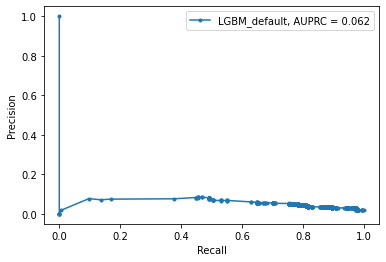

In [1571]:
LGBM_default_precision, LGBM_default_recall, _ = precision_recall_curve(
    y_test
    ,LGBM_default_model.predict(X_test_LGBM)
)

plt.plot(LGBM_default_recall, LGBM_default_precision, marker='.', label=
         'LGBM_default, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_default_model.predict(X_test_LGBM)),3))
        )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### The performance is very poor, maybe due to the extreme class imbalance

# Train another LGBM model, based on a resampled (balanced) training set

In [1572]:
y_sub_train.value_counts()

False    26432
True       395
Name: stroke, dtype: int64

In [1573]:
# Concat X and y for later resampling
X_y_sub_train = pd.concat(
    [X_sub_train, y_sub_train]
    ,axis = 1
    ,sort = False
)

# Concat all 'False' and resampled 'True' training instances
X_y_sub_train = pd.concat(
    [
        X_y_sub_train[X_y_sub_train['stroke']==False]
        ,X_y_sub_train[X_y_sub_train['stroke']==True].sample(
            n = 26432
            ,replace = True
            ,random_state = PRM_RND
        )
    ]
    ,axis = 0
    ,sort = False
)

# Validate the class distribution
X_y_sub_train['stroke'].value_counts()

True     26432
False    26432
Name: stroke, dtype: int64

In [1574]:
# Separate class from predictors
y_train_SAM = X_y_sub_train['stroke']
X_train_SAM = X_y_sub_train.drop('stroke', axis=1)

# labels
y_train_SAM_LGBM = y_train_SAM.values

# # Predictors
# X_train_SAM['gender'] = lb_gender.transform(X_train_SAM['gender'])
# X_train_SAM['work_type'] = lb_work_type.transform(X_train_SAM['work_type'])
# X_train_SAM['Residence_type'] = lb_Residence_type.transform(X_train_SAM['Residence_type'])
# X_train_SAM['smoking_status'] = lb_smoking_status.transform(X_train_SAM['smoking_status'])

# Change the type: Boolean to int
# for col in BOOLEAN_FEATURES:
#     X_train_SAM[col] = 1 * X_train_SAM[col]

X_train_SAM_LGBM = X_train_SAM.values

# LGBM-format dataset
train_data_SAM_LGBM = lgbm.Dataset(
    X_train_SAM_LGBM
    ,label=y_train_SAM_LGBM
    ,reference = train_data_LGBM
    ,categorical_feature = CATEGORICAL_FEATURES_TO_ENCODE + BOOLEAN_FEATURES
    ,feature_name = X_train_SAM.columns.tolist()
)

In [1575]:
LGBM_SAM_model = lgbm.train(
    {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'auc', #'map', # mean_average_precision, ~AUPRC #'auc',
        'is_unbalance': 'false',
#         'boosting': 'gbdt',
#         'num_leaves': 31,
#         'feature_fraction': 0.5, # default 1.0 # speed, over-fitting
#         'bagging_fraction': 0.5, # default 1.0 # speed, over-fitting
#         'bagging_freq': 20, # default 0 (disable), k means perform bagging at every k iteration
#         'learning_rate': 0.05, # default 0.1
#         'min_data_in_leaf': 100, # consider adding # over-fitting
#         'extra_trees': True, # consider adding # over-fitting
        'verbose': 0
    },
    train_data_SAM_LGBM,
    valid_sets=validation_data_LGBM,
#     num_boost_round=5000,
    early_stopping_rounds=100
)

C:\Users\Administrator\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.795695
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.817538
[3]	valid_0's auc: 0.826344
[4]	valid_0's auc: 0.827478
[5]	valid_0's auc: 0.832431
[6]	valid_0's auc: 0.833378
[7]	valid_0's auc: 0.833029
[8]	valid_0's auc: 0.832824
[9]	valid_0's auc: 0.837619
[10]	valid_0's auc: 0.835576
[11]	valid_0's auc: 0.834992
[12]	valid_0's auc: 0.835835
[13]	valid_0's auc: 0.834842
[14]	valid_0's auc: 0.835569
[15]	valid_0's auc: 0.837078
[16]	valid_0's auc: 0.836419
[17]	valid_0's auc: 0.837281
[18]	valid_0's auc: 0.837268
[19]	valid_0's auc: 0.83656
[20]	valid_0's auc: 0.836449
[21]	valid_0's auc: 0.835202
[22]	valid_0's auc: 0.835414
[23]	valid_0's auc: 0.832658
[24]	valid_0's auc: 0.832941
[25]	valid_0's auc: 0.833105
[26]	valid_0's auc: 0.832925
[27]	valid_0's auc: 0.833407
[28]	valid_0's auc: 0.833902
[29]	valid_0's auc: 0.831549
[30]	valid_0's auc: 0.830466
[31]	valid_0's auc: 0.828687
[32]	valid_0's auc: 0.828262
[33]	valid_0's auc: 

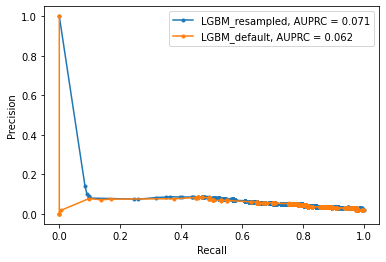

In [1576]:
LGBM_SAM_precision, LGBM_SAM_recall, _ = precision_recall_curve(
    y_test
    ,LGBM_SAM_model.predict(X_test_LGBM)
)

plt.plot(LGBM_SAM_recall, LGBM_SAM_precision, marker='.', label=
         'LGBM_resampled, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_SAM_model.predict(X_test_LGBM)),3))
        )
plt.plot(LGBM_default_recall, LGBM_default_precision, marker='.', label=
         'LGBM_default, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_default_model.predict(X_test_LGBM)),3))
        )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### The performance is slightly better yet very poor, maybe due to model overfitting

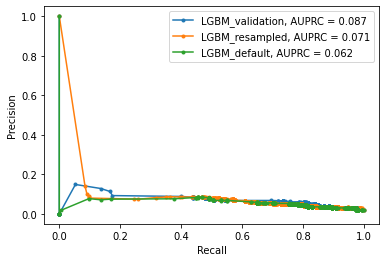

In [1577]:
LGBM_validation_precision, LGBM_validation_recall, _ = precision_recall_curve(
    y_validation
    ,LGBM_default_model.predict(X_validation_LGBM)
)

plt.plot(LGBM_validation_recall, LGBM_validation_precision, marker='.', label=
         'LGBM_validation, AUPRC = ' +\
         str(round(average_precision_score(y_validation, LGBM_SAM_model.predict(X_validation_LGBM)),3))
        )
plt.plot(LGBM_SAM_recall, LGBM_SAM_precision, marker='.', label=
         'LGBM_resampled, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_SAM_model.predict(X_test_LGBM)),3))
        )
plt.plot(LGBM_default_recall, LGBM_default_precision, marker='.', label=
         'LGBM_default, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_default_model.predict(X_test_LGBM)),3))
        )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### The performance is slightly better on the validation set yet very poor, maybe hyper-parameter tuning would assist

## Scaling and encoding

### Scale the numeric features into the range of [0, 1]

In [614]:
scaler = MinMaxScaler()
X_sub_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_sub_train[CONTINUOUS_FEATURES_TO_SCALE])
    ,columns = X_sub_train[CONTINUOUS_FEATURES_TO_SCALE].columns
)
# X_sub_train_scaled.head()

### Encode the categorical features

In [615]:
ohe = OneHotEncoder(categories='auto')
ohe_arr = ohe.fit_transform(X_sub_train[CATEGORICAL_FEATURES_TO_ENCODE]).toarray()
ohe_labels = ohe.categories_
ohe_labels = np.array(ohe_labels).ravel()
X_sub_train_encoded = pd.DataFrame(ohe_arr, columns=np.concatenate(ohe_labels, axis=0))
# X_sub_train_encoded.head()

## Concatenate scaled / encoded / boolean features

In [616]:
X_sub_train = pd.concat(
    objs = [
        X_sub_train_scaled
        ,X_sub_train_encoded
        ,X_sub_train[BOOLEAN_FEATURES].reset_index(drop = True, inplace = False)
    ]
    ,axis = 1
    ,sort = False
)

In [627]:
# Train an off-the-shelf classifier with default values set for the hyper-parameters
RF_default = RandomForestClassifier()
RF_default.fit(X_sub_train, y_sub_train)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [647]:
y_sub_train.value_counts()

False    26432
True       395
Name: stroke, dtype: int64

In [660]:
X_sub_train.head()

,age,avg_glucose_level,bmi,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban,formerly smoked,never smoked,smokes,unknown,hypertension,heart_disease,ever_married
0,0.438477,0.086507,0.828283,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,False,False,False
1,0.108887,0.171320,0.131313,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,False,False,False
2,0.975586,0.043296,0.595960,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,False,False,True
3,0.304199,0.029867,0.636364,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,False,False,False
4,0.719238,0.099174,0.774411,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,False,False


In [666]:
X_y_sub_train[X_y_sub_train['stroke']==True].sample(
            n = 26432
            ,replace = True
            ,random_state = PRM_RND
        )['ever_married'].value_counts()

True     9230
False    6419
Name: ever_married, dtype: int64

In [650]:
X_y_sub_train = pd.concat(
    [X_sub_train, y_sub_train]
    ,axis = 1
    ,sort = False
)

In [651]:
X_y_sub_train = pd.concat(
    [
        X_y_sub_train[X_y_sub_train['stroke']==False]
        ,X_y_sub_train[X_y_sub_train['stroke']==True].sample(
            n = 26432
            ,replace = True
            ,random_state = PRM_RND
        )
    ]
    ,axis = 0
    ,sort = False
)

In [652]:
X_y_sub_train['stroke'].value_counts()

True     26432
False    26432
Name: stroke, dtype: int64

In [667]:
# Train using the sampled data
RF_sampled = RandomForestClassifier()
RF_sampled.fit(X_y_sub_train.drop('stroke', axis = 1), X_y_sub_train['stroke'])

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [669]:
dd = X_y_sub_train.drop('stroke', axis = 1)
dd["hypertension"] = dd["hypertension"].astype(int)
dd["heart_disease"] = dd["heart_disease"].astype(int)
dd["ever_married"] = dd["ever_married"].astype(int)

ValueError: cannot convert float NaN to integer

In [653]:
# LGBM_train_data = lgbm.Dataset(X_sub_train, label=y_sub_train)
# LGBM_default = lgbm()

### Preprocess the validation set and apply the classifier

In [620]:
# Preprocess the training set
X_validation, y_validation = preprocess_dataset(X_validation, y_validation, 'validation')

In [621]:
# Scale
X_validation_scaled = pd.DataFrame(
    scaler.transform(X_validation[CONTINUOUS_FEATURES_TO_SCALE])
    ,columns = X_validation[CONTINUOUS_FEATURES_TO_SCALE].columns
)

# Encode
ohe_arr = ohe.transform(X_validation[CATEGORICAL_FEATURES_TO_ENCODE]).toarray()
ohe_labels = ohe.categories_
ohe_labels = np.array(ohe_labels).ravel()
X_validation_encoded = pd.DataFrame(ohe_arr, columns=np.concatenate(ohe_labels, axis=0))

# Concat
X_validation = pd.concat(
    objs = [
        X_validation_scaled
        ,X_validation_encoded
        ,X_validation[BOOLEAN_FEATURES].reset_index(drop = True, inplace = False)
    ]
    ,axis = 1
    ,sort = False
)

In [632]:
confusion_matrix(
    y_validation
    ,RF_default.predict(X_validation)
    ,labels = [True, False]
)

array([[   1,  131],
       [   3, 6809]], dtype=int64)

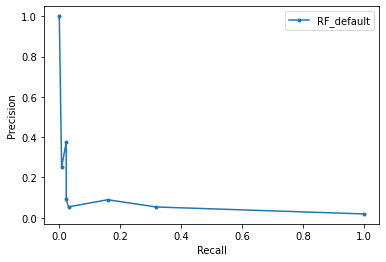

In [645]:
RF_default_precision, RF_default_recall, _ = precision_recall_curve(
    y_validation
    ,RF_default.predict_proba(X_validation)[:,1]
)

plt.plot(RF_default_recall, RF_default_precision, marker='.', label='RF_default')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()